In [11]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET

def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray.astype(np.float32))
    
    cap.release()
    return np.array(frames)

def get_bounding_boxes(mask, min_area=150):

    # mask must be 0/255 uint8
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    boxes = []

    for i in range(1, num_labels):  # skip background (label 0)

        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        if area >= min_area:  # filter small noise blobs
            box = [x, y, x + w, y + h]
            boxes.append(box)

    return boxes

def load_ground_truth(xml_path):

    tree = ET.parse(xml_path)
    root = tree.getroot()

    gt_per_frame = {}

    for track in root.findall("track"):

        for box in track.findall("box"):

            frame = int(box.get("frame"))
            outside = int(box.get("outside"))

            # Ignore boxes not visible
            if outside == 1:
                continue

            # Check parked attribute
            parked = False
            for attr in box.findall("attribute"):
                if attr.get("name") == "parked":
                    if attr.text == "true":
                        parked = True

            if parked:
                continue

            xtl = float(box.get("xtl"))
            ytl = float(box.get("ytl"))
            xbr = float(box.get("xbr"))
            ybr = float(box.get("ybr"))

            bbox = [xtl, ytl, xbr, ybr]

            if frame not in gt_per_frame:
                gt_per_frame[frame] = []

            gt_per_frame[frame].append(bbox)

    return gt_per_frame

def compute_iou(boxA, boxB):

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])

    union = boxAArea + boxBArea - interArea

    return interArea / union if union > 0 else 0

In [2]:
video_path = "/DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/vdo.avi"
frames = load_video_frames(video_path)

print("Total frames:", len(frames))


N = len(frames)
train_end = int(0.25 * N)

train_frames = frames[:train_end]
test_frames = frames[train_end:]

print("Training frames:", len(train_frames))
print("Testing frames:", len(test_frames))

Total frames: 2141
Training frames: 535
Testing frames: 1606


In [ ]:
train_frames = train_frames.astype(np.float32)
test_frames = test_frames.astype(np.float32)

mu = np.mean(train_frames, axis=0)
sigma = np.std(train_frames, axis=0)

roi = cv2.imread("/DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/roi.jpg", cv2.IMREAD_GRAYSCALE)
roi = roi > 0

alpha = 2
kernel = np.ones((5,5), np.uint8)
foreground_masks = []

for frame in test_frames:

    diff = np.abs(frame - mu)

    sigma_safe = np.maximum(sigma, 1e-6)
    mask = diff >= alpha * (sigma_safe + 2)

    mask = mask & roi
    mask = mask.astype(np.uint8) * 255

    erosion = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(erosion, kernel, iterations=1)

    foreground_masks.append(mask)

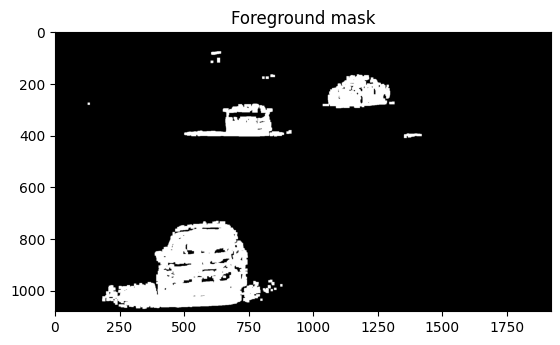

In [10]:
import matplotlib.pyplot as plt

plt.imshow(foreground_masks[20], cmap="gray")
plt.title("Foreground mask")
plt.show()

In [25]:
all_pred_boxes = []

for mask in foreground_masks:
    boxes = get_bounding_boxes(mask, min_area=1000)
    all_pred_boxes.append(boxes)

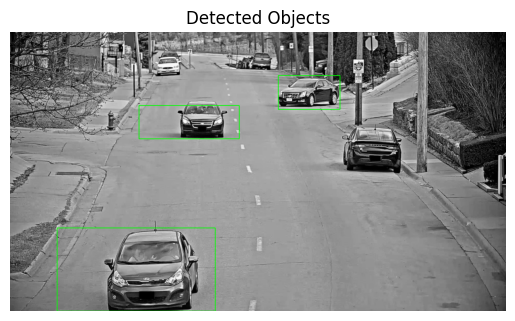

In [26]:
import matplotlib.pyplot as plt

frame_idx = 21 

frame = test_frames[frame_idx].astype(np.uint8)
boxes = all_pred_boxes[frame_idx]

frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

for box in boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(frame_color, (x1, y1), (x2, y2), (0,255,0), 2)

plt.imshow(frame_color)
plt.title("Detected Objects")
plt.axis("off")
plt.show()